In [255]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import collections
import warnings
warnings.filterwarnings("ignore")

 -Здесь мы будет прогнозировать, что человек просрочит выплаты по кредиту на 3 месяца и более (целевой признак - Delinquent90).

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

In [256]:
train_data = pd.read_csv("Downloads/data/credit_scoring_train.csv")
test_data = pd.read_csv("Downloads/data/credit_scoring_test.csv")

all_data = pd.concat([train_data, test_data])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 74999
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   client_id              150000 non-null  int64  
 1   DIR                    150000 non-null  float64
 2   Age                    150000 non-null  float64
 3   NumLoans               150000 non-null  int64  
 4   NumRealEstateLoans     150000 non-null  int64  
 5   NumDependents          146076 non-null  float64
 6   Num30-59Delinquencies  150000 non-null  int64  
 7   Num60-89Delinquencies  150000 non-null  int64  
 8   Income                 120269 non-null  float64
 9   BalanceToCreditLimit   150000 non-null  float64
 10  Delinquent90           75000 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 13.7 MB


In [257]:
all_data.drop(columns = "Delinquent90").isna().sum()

client_id                    0
DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             3924
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   29731
BalanceToCreditLimit         0
dtype: int64

In [258]:
# Check for duplicates
index_unique = len(set(train_data['client_id']))
index_total = train_data.shape[0]
index_duplicate = index_total - index_unique
print("There are " + str(index_duplicate) + " duplicate IDs for " + str(index_total) + " total entries")

There are 0 duplicate IDs for 75000 total entries


In [259]:
train_data.drop("client_id", axis = 1, inplace = True)
train_data["NumDependents"].fillna(train_data["NumDependents"].median(), inplace=True)
train_data["Income"].fillna(train_data["Income"].median(), inplace=True)

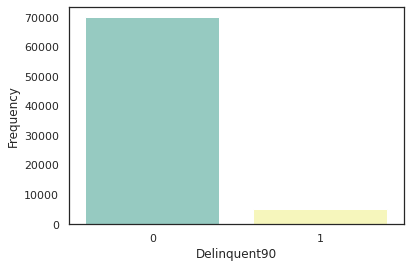

In [260]:
sns.set(style='white', context='notebook', palette='deep')
ax = sns.countplot(x = train_data.Delinquent90, palette="Set3")
ax.set_xlabel('Delinquent90')
ax.set_ylabel('Frequency')
plt.show()

In [261]:
train_data.describe(percentiles=[0.2, 0.4, 0.6, 0.8])

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
count,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04,75000.000000,75000.000000
mean,353.260293,52.595605,8.44976,1.016693,0.736653,0.428320,0.248000,6.479642e+03,6.276196,0.066840
std,2117.237432,14.869729,5.15644,1.124019,1.100357,4.276439,4.239486,1.275356e+04,267.743321,0.249746
min,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
20%,0.134238,39.100000,4.00000,0.000000,0.000000,0.000000,0.000000,3.417880e+03,0.019069,0.000000
40%,0.288886,48.200000,6.00000,1.000000,0.000000,0.000000,0.000000,5.416644e+03,0.083070,0.000000
50%,0.366848,52.200000,8.00000,1.000000,0.000000,0.000000,0.000000,5.424552e+03,0.153720,0.000000
60%,0.467769,56.400000,9.00000,1.000000,0.000000,0.000000,0.000000,5.430857e+03,0.271751,0.000000
80%,3.647766,65.300000,12.00000,2.000000,2.000000,0.000000,0.000000,8.309490e+03,0.700804,0.000000
max,332600.272820,109.800000,56.00000,32.000000,20.000000,98.000000,98.000000,1.805573e+06,50873.874533,1.000000


In [262]:
def detect_outliers(df):
    
    data = df[df["Delinquent90"]==0].drop(columns="Delinquent90")
    
    outlier_indices = []
    for col in data.columns:
        IQR = np.percentile(data[col], 80)
        outlier_list_col = data[data[col] > IQR].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = collections.Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2)



    df = df.drop(multiple_outliers, axis=0).reset_index(drop=True)

    return multiple_outliers

In [263]:
train_data.loc[detect_outliers(train_data)]

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
2,2206.731199,55.5,21,1,0.0,1,0,5424.552473,0.348227,0
81,2666.231357,63.4,16,1,0.0,6,1,5424.552473,0.570821,0
90,10788.752948,76.7,13,6,0.0,0,0,5424.552473,0.116273,0
111,3034.798634,67.3,15,2,2.0,0,0,5424.552473,0.601902,0
138,619.516245,51.4,5,0,3.0,0,0,5424.552473,1.067577,0
...,...,...,...,...,...,...,...,...,...,...
61847,0.391230,39.0,6,1,1.0,0,1,9042.562174,1.000959,0
63958,0.391264,50.4,11,2,1.0,0,1,10504.163656,1.001888,0
66251,0.209562,38.1,7,1,2.0,0,2,16005.236304,1.000643,0
69720,0.516579,51.4,5,2,2.0,0,1,8423.370587,0.897676,0


In [264]:
train_data = train_data.drop(detect_outliers(train_data), axis = 0).reset_index(drop=True)

In [265]:
train_data

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,886.132793,55.3,3,0,0.0,0,0,5424.552473,0.971930,0
3,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0
4,0.461193,71.3,9,0,0.0,0,0,3562.767475,0.039618,0
...,...,...,...,...,...,...,...,...,...,...
66621,0.169463,67.6,5,1,0.0,0,0,20129.654428,0.074689,0
66622,2085.662215,43.2,1,1,0.0,0,0,5424.552473,1.005390,0
66623,0.118935,23.0,4,0,0.0,2,0,2019.117329,0.384511,0
66624,0.203414,46.3,14,2,0.0,0,0,16823.909642,0.524093,0


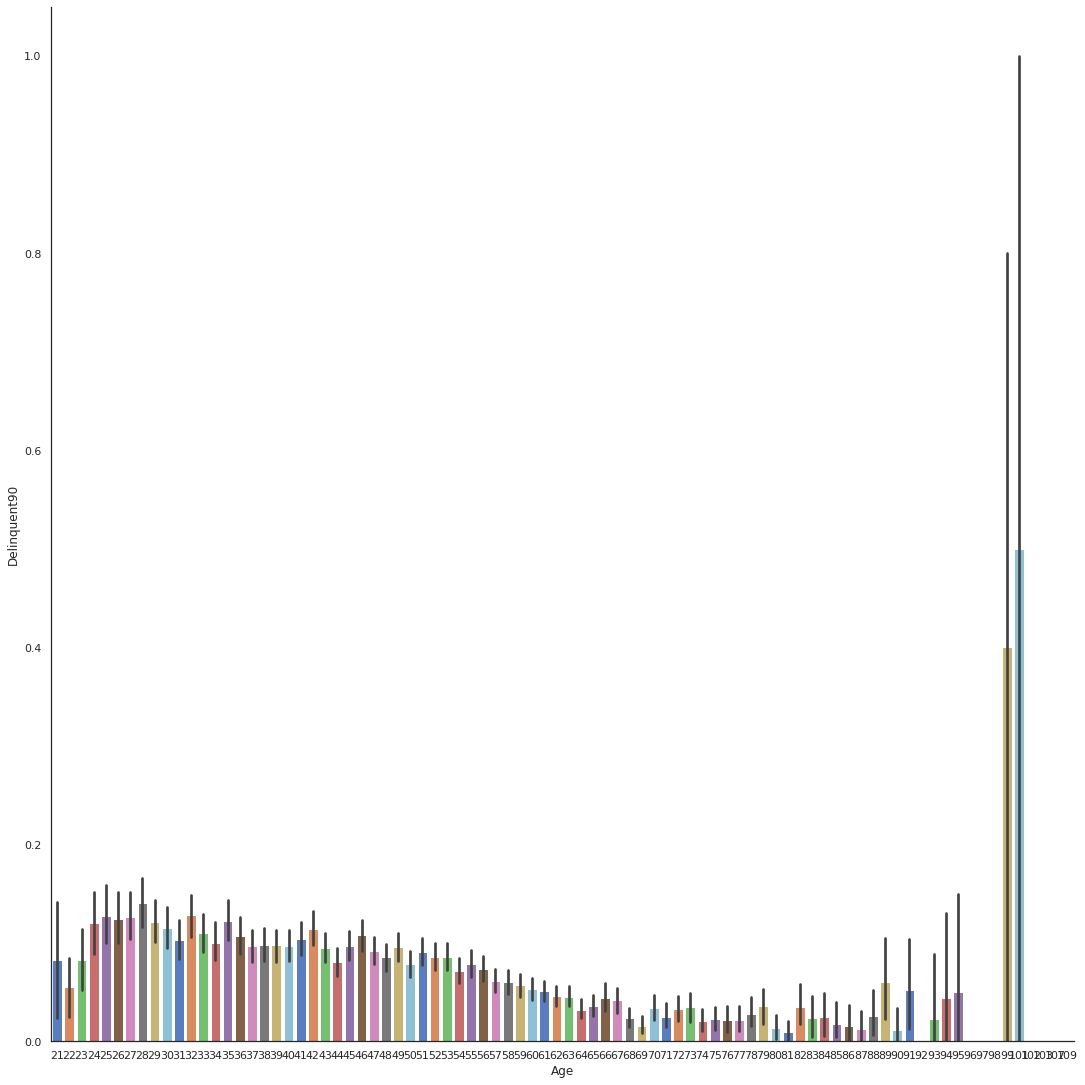

In [266]:
train_data.Age = train_data.Age.astype(int)
sns.factorplot(x="Age", y="Delinquent90",data=train_data, kind="bar", size=15, palette = "muted")

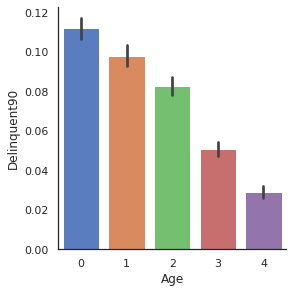

In [267]:
train_data.Age = pd.qcut(train_data.Age.values, 5).codes
sns.factorplot(x="Age", y="Delinquent90",data=train_data, kind="bar", size=4, palette = "muted")

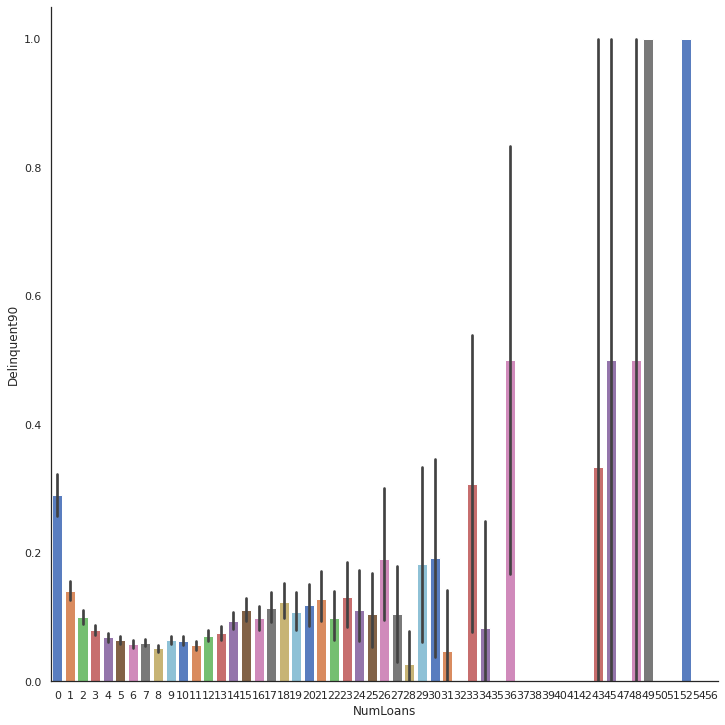

In [268]:
sns.factorplot(x="NumLoans", y="Delinquent90",data=train_data, kind="bar", size=10, palette = "muted")

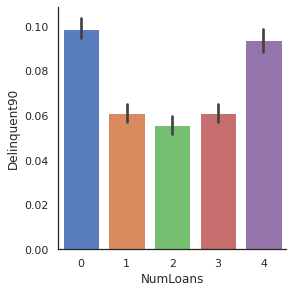

In [269]:
train_data.NumLoans = pd.qcut(train_data.NumLoans.values, 5).codes
sns.factorplot(x="NumLoans", y="Delinquent90",data=train_data, kind="bar", size=4, palette = "muted")

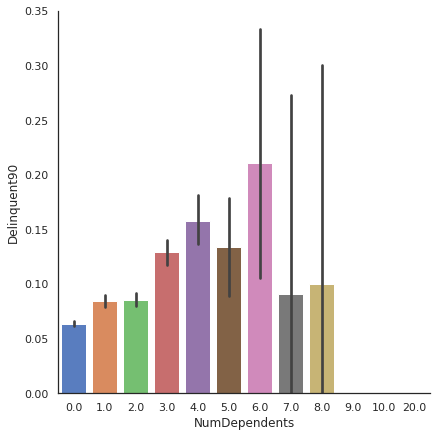

In [270]:
sns.factorplot(x="NumDependents", y="Delinquent90",data=train_data, kind="bar", size=6, palette = "muted")

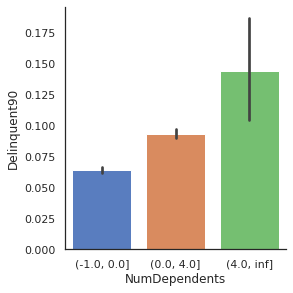

In [271]:
train_data.NumDependents = pd.cut(train_data.NumDependents, bins=[-1, 0, 4, np.inf])
sns.factorplot(x="NumDependents", y="Delinquent90",data=train_data, kind="bar", size=4, palette = "muted")

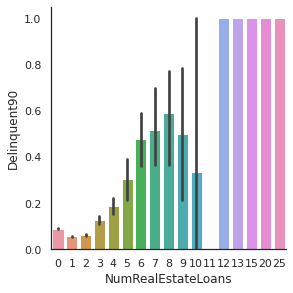

In [272]:
sns.factorplot(x='NumRealEstateLoans', y="Delinquent90",data=train_data, kind="bar", size=4)

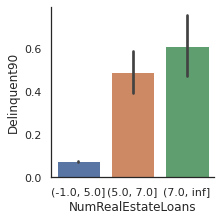

In [273]:
train_data.NumRealEstateLoans = pd.cut(train_data.NumRealEstateLoans, bins=[-1,5,7,np.inf])
sns.factorplot(x='NumRealEstateLoans', y="Delinquent90", data=train_data, kind="bar", size=3)

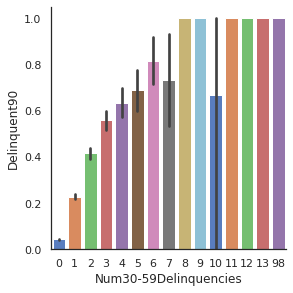

In [274]:
sns.factorplot(x="Num30-59Delinquencies", y="Delinquent90",data=train_data, kind="bar", size=4, palette = "muted")

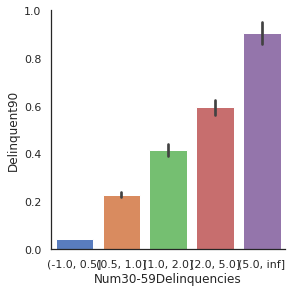

In [275]:
train_data["Num30-59Delinquencies"] = pd.cut(train_data["Num30-59Delinquencies"],
                                             bins = [-1, 0.5, 1, 2, 5, np.inf])
sns.factorplot(x="Num30-59Delinquencies", y="Delinquent90",data=train_data, kind="bar", size=4, palette = "muted")

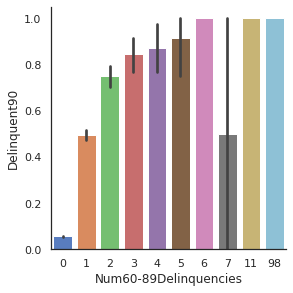

In [276]:
sns.factorplot(x="Num60-89Delinquencies", y="Delinquent90",data=train_data, kind="bar", size=4, palette = "muted")

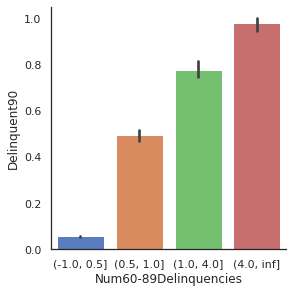

In [277]:
train_data["Num60-89Delinquencies"] = pd.cut(train_data["Num60-89Delinquencies"],
                                             bins = [-1, 0.5,1, 4, np.inf])
sns.factorplot(x="Num60-89Delinquencies", y="Delinquent90",data=train_data, kind="bar", size=4, palette = "muted")

In [278]:
train_data = pd.get_dummies(train_data, columns = ["Age"], prefix="Age")
train_data = pd.get_dummies(train_data, columns = ["NumLoans"], prefix="NumLoans")
train_data = pd.get_dummies(train_data, columns = ['Num30-59Delinquencies'], prefix="Num30-59")
train_data = pd.get_dummies(train_data, columns = ["Num60-89Delinquencies"], prefix="Num60-89")
train_data = pd.get_dummies(train_data, columns = ["NumDependents"], prefix="NumDependents")
train_data = pd.get_dummies(train_data, columns = ["NumRealEstateLoans"], prefix="NumRealEstateLoans")

In [279]:
train_data

,DIR,Income,BalanceToCreditLimit,Delinquent90,Age_0,Age_1,Age_2,Age_3,Age_4,NumLoans_0,...,"Num60-89_(-1.0, 0.5]","Num60-89_(0.5, 1.0]","Num60-89_(1.0, 4.0]","Num60-89_(4.0, inf]","NumDependents_(-1.0, 0.0]","NumDependents_(0.0, 4.0]","NumDependents_(4.0, inf]","NumRealEstateLoans_(-1.0, 5.0]","NumRealEstateLoans_(5.0, 7.0]","NumRealEstateLoans_(7.0, inf]"
0,0.496289,5298.360639,0.387028,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,0.433567,6008.056256,0.234679,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,886.132793,5424.552473,0.971930,0,0,0,1,0,0,1,...,1,0,0,0,1,0,0,1,0,0
3,0.000000,2504.613105,1.004350,0,0,0,1,0,0,1,...,1,0,0,0,1,0,0,1,0,0
4,0.461193,3562.767475,0.039618,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66621,0.169463,20129.654428,0.074689,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
66622,2085.662215,5424.552473,1.005390,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
66623,0.118935,2019.117329,0.384511,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
66624,0.203414,16823.909642,0.524093,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


In [280]:
numerical=['DIR','Income','BalanceToCreditLimit']
features=train_data.drop(columns="Delinquent90")
target=train_data['Delinquent90']

In [281]:
rseed = 0
X_train, X_test, y_train, y_test = train_test_split(features,
                                                   target,
                                                   test_size=0.3,
                                                   random_state=rseed,
                                                   stratify=target)

In [282]:
stdSc = StandardScaler()
X_train_num = stdSc.fit_transform(X_train[numerical])
X_test_num = stdSc.transform(X_test[numerical])
X_train[numerical]=X_train_num
X_test[numerical]=X_test_num

In [283]:
metrics = pd.DataFrame({"score_type":["balanced_accuracy", "f1", "roc_auc", "conf_metrix"]})
metrics.set_index("score_type")

def quality_model(model, model_name):
    
    metrics[model_name] = [np.round(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="balanced_accuracy")),3),
                            np.round(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="f1")),3),
                            np.round(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")),3),
                            confusion_matrix(y_test, model.predict(X_test))
                          ]
    return metrics

In [284]:
sgd = SGDClassifier()
log_reg = LogisticRegression()
rand_forest = RandomForestClassifier()


for model, model_name in zip([sgd, log_reg, rand_forest], ["sgd", "log_reg", "random_forest"]):
    model.fit(X_train, y_train)
    quality_model(model, model_name)
metrics

,score_type,sgd,log_reg,random_forest
0,balanced_accuracy,0.601,0.614,0.667
1,f1,0.323,0.357,0.47
2,roc_auc,0.763,0.82,0.839
3,conf_metrix,"[[18297, 187], [1214, 290]]","[[18359, 125], [1151, 353]]","[[18275, 209], [963, 541]]"


In [285]:
sgd_params = {'class_weight': {1: 0.9, 0: 0.1},
              "penalty": "l2",
              'n_iter_no_change':15,
              "max_iter": 5,
              "random_state":rseed,
              "n_jobs":-1}

lr_params = {'penalty':'l2', 
            'random_state':rseed,
            'n_jobs':-1,
            'class_weight':"balanced"}

rf_params = {"n_estimators":30,
             "max_features":None,
             "class_weight":{1: 0.9, 0: 0.1},
             "min_samples_split": 15,
             "min_samples_leaf": 6,
             "max_samples":0.2,
             "random_state":rseed,
             "n_jobs":-1}

sgd= SGDClassifier(**sgd_params)
lr = LogisticRegression(**lr_params)
rf = RandomForestClassifier(**rf_params)

In [286]:
%%time

grid_param_sgd = {'alpha': np.arange(0.0001, 0.001, 0.0001),
                'eta0': [1, 10, 100],
                'loss': ['modified_huber', 'hinge', 'log'],
                'learning_rate': ['invscaling', 'adaptive', 'optimal']}

grid_param_lg = {'C': np.arange(0.00001, 0.0001, 0.00001),
                'solver': ['liblinear','sag']}

grid_param_rf = {"max_depth":range(5,20)}

cv_results = {}
for model, model_params, model_name in zip([sgd, lr, rf],
                                           [grid_param_sgd, grid_param_lg, grid_param_rf],
                                           ["best_sgd", "best_lr", "best_rf"]):
    
    gs = GridSearchCV(model, model_params, cv=3, scoring="f1", n_jobs=-1)
    gs_result = gs.fit(X_train, y_train)                     
    
    quality_model(gs_result.best_estimator_, model_name)
    
    cv_results[model_name] = gs_result.cv_results_
    print(f'Best {model.__class__.__name__} Params: ', gs_result.best_params_) 

Best SGDClassifier Params:  {'alpha': 0.0009000000000000001, 'eta0': 1, 'learning_rate': 'optimal', 'loss': 'log'}
Best LogisticRegression Params:  {'C': 9e-05, 'solver': 'liblinear'}
Best RandomForestClassifier Params:  {'max_depth': 17}
CPU times: user 36.5 s, sys: 7 s, total: 43.5 s
Wall time: 5min 25s


In [287]:
metrics

,score_type,sgd,log_reg,random_forest,best_sgd,best_lr,best_rf
0,balanced_accuracy,0.601,0.614,0.667,0.74,0.726,0.731
1,f1,0.323,0.357,0.47,0.419,0.409,0.508
2,roc_auc,0.763,0.82,0.839,0.819,0.805,0.864
3,conf_metrix,"[[18297, 187], [1214, 290]]","[[18359, 125], [1151, 353]]","[[18275, 209], [963, 541]]","[[16789, 1695], [634, 870]]","[[16763, 1721], [661, 843]]","[[17800, 684], [747, 757]]"


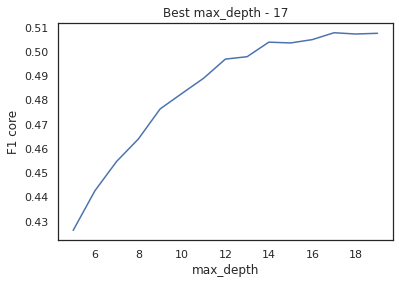

In [288]:
x = cv_results["best_rf"]['param_max_depth'].tolist()
y = cv_results["best_rf"]['mean_test_score'].tolist()

plt.plot(x,y)
plt.xlabel("max_depth")
plt.ylabel("F1 core")
plt.title("Best max_depth - {}".format(x[np.argmax(y)]))
plt.show()

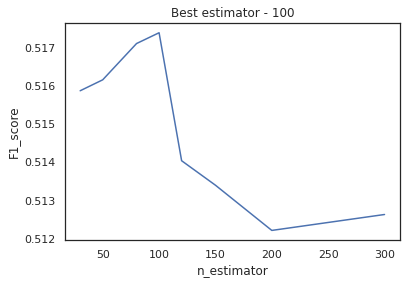

In [289]:
n_estimator = [30,50,80,100,120,150,200,300]
f1 =[]
for n in n_estimator:
    
    rf_params = {"n_estimators":n,
             "max_features":None,
             "class_weight":{1: 0.9, 0: 0.1},
             "min_samples_split": 15,
             "min_samples_leaf": 6,
             "max_samples":0.2,
             "max_depth":19,
             "random_state":rseed,
             "n_jobs":-1}
    
    rf = RandomForestClassifier(**rf_params).fit(X_train, y_train)
    f1.append(f1_score(rf.predict(X_test), y_test))
    
plt.plot(n_estimator, f1)
plt.title("Best estimator - {}".format(n_estimator[np.argmax(f1)]))
plt.xlabel("n_estimator")
plt.ylabel("F1_score")
plt.show()

In [290]:
best_rf_params = {"n_estimators":100,
             "max_features":None,
             "class_weight":{1: 0.9, 0: 0.1}, 
             "min_samples_split": 15,
             "min_samples_leaf": 6,
             "max_depth":17,
             "max_samples":0.2,
             "random_state":rseed,
             "n_jobs":-1}

best_rf = RandomForestClassifier(**best_rf_params).fit(X_train, y_train)
quality_model(best_rf, "Best_rf")

,score_type,sgd,log_reg,random_forest,best_sgd,best_lr,best_rf,Best_rf
0,balanced_accuracy,0.601,0.614,0.667,0.74,0.726,0.731,0.729
1,f1,0.323,0.357,0.47,0.419,0.409,0.508,0.513
2,roc_auc,0.763,0.82,0.839,0.819,0.805,0.864,0.868
3,conf_metrix,"[[18297, 187], [1214, 290]]","[[18359, 125], [1151, 353]]","[[18275, 209], [963, 541]]","[[16789, 1695], [634, 870]]","[[16763, 1721], [661, 843]]","[[17800, 684], [747, 757]]","[[17808, 676], [748, 756]]"


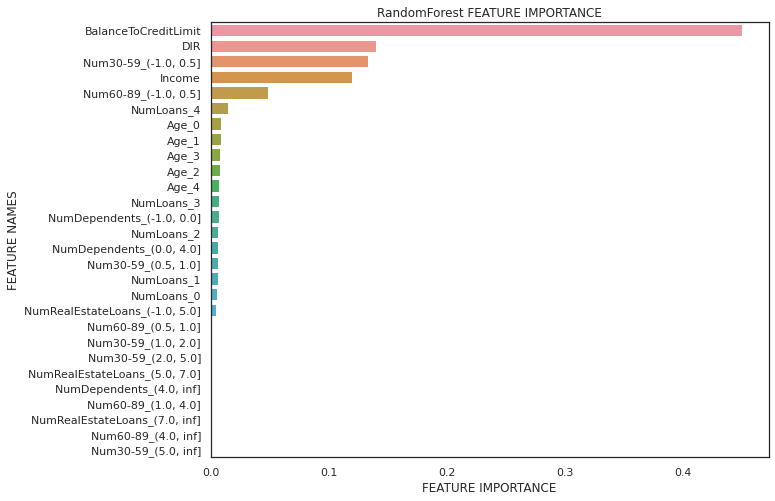

In [291]:
def plot_feature_importance(importance, names):

    data={'feature_names':names, 'feature_importance':importance}
    fi_df = pd.DataFrame(data).sort_values(by='feature_importance', ascending=False)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data=fi_df)
    
    plt.title('RandomForest FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(best_rf.feature_importances_, features.columns)

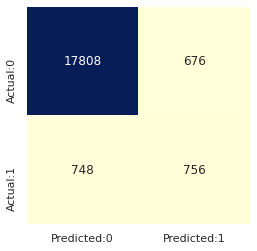

In [292]:
cm = confusion_matrix(y_test, best_rf.predict(X_test))
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", cbar=False);